In [ ]:
import numpy as np
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler


# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 64

In [ ]:
def get_train_valid_loader(data_dir,
                           batch_size,
                           augment,
                           random_seed,
                           valid_size=0.1,
                           shuffle=True):
    normalize = transforms.Normalize(
        mean=[0.4914, 0.4822, 0.4465],
        std=[0.2023, 0.1994, 0.2010],
    )

    # define transforms
    valid_transform = transforms.Compose([
            transforms.Resize((227,227)),
            transforms.ToTensor(),
            normalize,
    ])
    if augment:
        train_transform = transforms.Compose([
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            normalize,
        ])
    else:
        train_transform = transforms.Compose([
            transforms.Resize((227,227)),
            transforms.ToTensor(),
            normalize,
        ])

    # load the dataset
    train_dataset = datasets.GTSRB(
        root=data_dir, split='train',
        download=True, transform=train_transform,
    )

    valid_dataset = datasets.GTSRB(
        root=data_dir, split='train',
        download=True, transform=valid_transform,
    )

    num_train = len(train_dataset)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))

    if shuffle:
        np.random.seed(random_seed)
        np.random.shuffle(indices)

    train_idx, valid_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, sampler=train_sampler)
 
    valid_loader = torch.utils.data.DataLoader(
        valid_dataset, batch_size=batch_size, sampler=valid_sampler)

    return (train_loader, valid_loader)


def get_test_loader(data_dir,
                    batch_size,
                    shuffle=True):
    normalize = transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    )

    # define transform
    transform = transforms.Compose([
        transforms.Resize((227,227)),
        transforms.ToTensor(),
        normalize,
    ])

    dataset = datasets.GTSRB(
        root=data_dir, split='test',
        download=True, transform=transform,
    )

    data_loader = torch.utils.data.DataLoader(
        dataset, batch_size=batch_size, shuffle=shuffle
    )

    return data_loader


# CIFAR10 dataset 
train_loader, valid_loader = get_train_valid_loader(data_dir = './data',                                      batch_size = 64,
                       augment = False,                             		     random_seed = 1)

test_loader = get_test_loader(data_dir = './data',
                              batch_size = 64)

In [ ]:

class AlexNet(nn.Module):
    def __init__(self, num_classes=43):
        super(AlexNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=0),
            nn.BatchNorm2d(96),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU())
        self.layer5 = nn.Sequential(
            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(9216, 4096),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU())
        self.fc2= nn.Sequential(
            nn.Linear(4096, num_classes))
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

In [ ]:
num_classes = 43
num_epochs = 10
batch_size = 64
learning_rate = 0.0001

model = AlexNet(num_classes).to(device)


# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay = 0.005, momentum = 0.9)  


# Train the model
total_step = len(train_loader)
print(device)



cuda


In [ ]:
import time
start_time = time.time()
total_step = len(train_loader)
accuracy_list = []

steps_list = []

for epoch in range(num_epochs):
  for i, data in enumerate(train_loader):
    images, labels = data[0].to(device), data[1].to(device)

    #Forward Pass
    outputs = model(images)
    loss = criterion(outputs, labels)

    #Backpropogation and Optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    #Train Accuracy
    total = labels.size(0)
    _, predicted = torch.max(outputs.data,1)

    correct = (predicted == labels).sum().item()
    
    steps = i + 1
    
    if(i + 1) % 100 == 0:

      accuracy = (correct / total) * 100
      accuracy_list.append(accuracy)
      steps_list.append(steps)
      print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
              .format(epoch + 1, num_epochs, steps, total_step, loss.item(),
                    accuracy))

print("######## Training Finished in {} seconds ###########".format(time.time()-start_time))
print("Accuracy List: ",accuracy_list, "Steps List: ",steps_list)

Epoch [1/10], Step [100/375], Loss: 3.4629, Accuracy: 10.94%
Epoch [1/10], Step [200/375], Loss: 3.2177, Accuracy: 15.62%
Epoch [1/10], Step [300/375], Loss: 3.2938, Accuracy: 17.19%
Epoch [2/10], Step [100/375], Loss: 2.9201, Accuracy: 20.31%
Epoch [2/10], Step [200/375], Loss: 2.7296, Accuracy: 40.62%
Epoch [2/10], Step [300/375], Loss: 2.7530, Accuracy: 29.69%
Epoch [3/10], Step [100/375], Loss: 2.3416, Accuracy: 37.50%
Epoch [3/10], Step [200/375], Loss: 2.1778, Accuracy: 42.19%
Epoch [3/10], Step [300/375], Loss: 2.0282, Accuracy: 45.31%
Epoch [4/10], Step [100/375], Loss: 1.8396, Accuracy: 51.56%
Epoch [4/10], Step [200/375], Loss: 1.8082, Accuracy: 43.75%
Epoch [4/10], Step [300/375], Loss: 1.4771, Accuracy: 62.50%
Epoch [5/10], Step [100/375], Loss: 1.4402, Accuracy: 54.69%
Epoch [5/10], Step [200/375], Loss: 1.5498, Accuracy: 56.25%
Epoch [5/10], Step [300/375], Loss: 1.1633, Accuracy: 65.62%
Epoch [6/10], Step [100/375], Loss: 1.0999, Accuracy: 67.19%
Epoch [6/10], Step [200/

In [ ]:

print("Accuracy List: ",accuracy_list, "Steps List: ",steps_list)
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        del images, labels, outputs

    print('Accuracy of the network on the {} test images: {} %'.format(10000, 100 * correct / total)) 

Accuracy List:  [10.9375, 15.625, 17.1875, 20.3125, 40.625, 29.6875, 37.5, 42.1875, 45.3125, 51.5625, 43.75, 62.5, 54.6875, 56.25, 65.625, 67.1875, 78.125, 78.125, 65.625, 79.6875, 79.6875, 81.25, 82.8125, 75.0, 85.9375, 89.0625, 84.375, 79.6875, 89.0625, 85.9375] Steps List:  [100, 200, 300, 100, 200, 300, 100, 200, 300, 100, 200, 300, 100, 200, 300, 100, 200, 300, 100, 200, 300, 100, 200, 300, 100, 200, 300, 100, 200, 300]
Accuracy of the network on the 10000 test images: 82.14568487727632 %


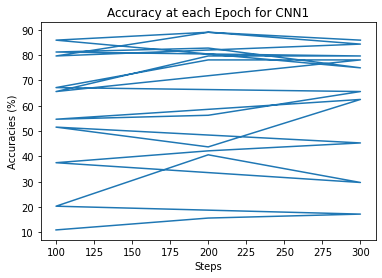

In [ ]:
import matplotlib.pyplot as pyplot
import numpy as np

x_axis = np.array(steps_list)
y_axis = np.array(accuracy_list)

pyplot.title("Accuracy at each Epoch for CNN1")
pyplot.xlabel("Steps")
pyplot.ylabel("Accuracies (%)")
pyplot.plot(x_axis, y_axis)

pyplot.show()

In [25]:
# Specify a path
PATH = "/content/AlexnetAll"

# Save
torch.save(model, PATH)

In [26]:
torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            'accuracy_list':accuracy_list,
            'step_list':steps_list
            }, PATH)

In [17]:
!zip '/content/Alexnet.pt'

  adding: content/Alexnet.pt (deflated 8%)
